# **Spectral Index Evaluation of Land Use Compliance with the PBOT in La Ceja**
This project aims to analyze and quantify the urban expansion in La Ceja, a municipality located in Eastern Antioquia (Colombia), between the years 2018 and 2025. Using Sentinel-2 multispectral satellite imagery, we calculate spectral indices such as NDVI (Normalized Difference Vegetation Index) and NDBI (Normalized Difference Built-up Index) to detect changes in vegetation cover and built-up areas.

These spatial transformations are then compared with the urban growth zones defined in the Municipal Land Use Plan (PBOT) established by Agreement 001 of 2018. The overlay between remote sensing analysis and official planning boundaries allows us to assess whether recent urban development has occurred within legally designated areas or has exceeded regulated expansion zones.

This approach provides technical evidence to support sustainable territorial management, monitor compliance with planning regulations, and inform future decision-making by local authorities. The project also explores the effectiveness of remote sensing as a tool for land-use monitoring in rapidly growing intermediate municipalities.


## Libraries and necessary packs

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import glob
import os
from tqdm import tqdm
from IPython.display import display

## Upload and stack verification

Code to verify the content of archives ".tif", it makes the band decomposition, index and description of each one

In [21]:
import rasterio
import os

stack_dir = "./carpeta_stacks" # Stacks directory
for filename in os.listdir(stack_dir):
    if filename.endswith(".tif"):
        file_path = os.path.join(stack_dir, filename)
        with rasterio.open(file_path) as src_file:
            print(f"File: {filename}")
            print("Number of bands:", src_file.count)
            print("Available index from bands:", src_file.indexes)
            desc = src_file.descriptions
            if desc is None:
                print("No descriptions available.")
            else:
                for idx, d in enumerate(desc, start=1):
                    print(f"Band {idx}: {d}")
            print("-" * 40) # Separator for clarity


File: 2018-08-07_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-01-04_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-07-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2019-08-27_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-01-09_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2020-02-18_stack3.tif
Number of bands: 3
Available index from bands: (1, 2, 3)
Band 1: NDVI
Band 2: NDBI
Band 3: UI
----------------------------------------
File: 2023-08-26_stack

This section loads our training points from the GeoPackage "muestras_training.gpkg" obtained with QGIS previously ("points_training" layer), finds all multiband GeoTIFF “stacks” (each containing NDVI, NDBI and UI bands), and samples those three index values at every training point location.  

- **Load**: Read the "points_training" layer with GeoPandas.  
- **List**: Use "glob" to locate all stack files matching the given pattern.  
- **Sample**: For each stack, open it with Rasterio and sample the NDVI, NDBI, and UI bands at each point’s (x, y).  
- **Assemble**: Build a single pandas "DataFrame" ("df_samples") with columns:
  - `raster_date`: scene date (parsed from filename)  
  - `point_date`: original sampling date  
  - `label`: land-cover class  
  - `x`, `y`: point coordinates  
  - `NDVI`, `NDBI`, `UI`: extracted index values  
- **Inspect**: Print dimensions and display the first few rows to verify the results.


In [22]:
# Parameters
gpkg_path = './carpeta_stacks/muestras_training.gpkg'
layer_name = 'points_training'
stacks_path_pattern = './carpeta_stacks/*.tif'

# 1) Upload and verify training points
gdf = gpd.read_file(gpkg_path, layer=layer_name)
coords = [(pt.x, pt.y) for pt in gdf.geometry]

# 2) List all raster files matching the pattern
raster_files = sorted(glob.glob(stacks_path_pattern))
print(f"find {len(raster_files)} stacks:")
for fp in raster_files:
    print(" •", fp)

# 3) Get samples from each raster stack
records = []
for rf in tqdm(raster_files, desc="Procesing stacks"):
    date_str = os.path.splitext(os.path.basename(rf))[0]
    with rasterio.open(rf) as src:
        samples = list(src.sample(coords))
        for (ndvi, ndbi, ui), row in zip(samples, gdf.itertuples()):
            records.append({
                'raster_date': date_str,
                'point_date': row.date,
                'label': row.label,
                'x': row.geometry.x,
                'y': row.geometry.y,
                'NDVI': ndvi,
                'NDBI': ndbi,
                'UI': ui
            })

# 4) build a DataFrame from the records
df_samples = pd.DataFrame.from_records(records)

# 5) Display the DataFrame
print("\nDataFrame dimension:", df_samples.shape)
print("Columns:", df_samples.columns.tolist())
display(df_samples.head(10))

find 7 stacks:
 • ./carpeta_stacks\2018-08-07_stack3.tif
 • ./carpeta_stacks\2019-01-04_stack3.tif
 • ./carpeta_stacks\2019-07-18_stack3.tif
 • ./carpeta_stacks\2019-08-27_stack3.tif
 • ./carpeta_stacks\2020-01-09_stack3.tif
 • ./carpeta_stacks\2020-02-18_stack3.tif
 • ./carpeta_stacks\2023-08-26_stack3.tif


Procesing stacks: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


DataFrame dimension: (52920, 8)
Columns: ['raster_date', 'point_date', 'label', 'x', 'y', 'NDVI', 'NDBI', 'UI']


,raster_date,point_date,label,x,y,NDVI,NDBI,UI
0,2018-08-07_stack3,2019-07-18,1,-75.428738,6.030611,0.113764,0.151539,0.142384
1,2018-08-07_stack3,2019-07-18,1,-75.431324,6.032770,0.144415,0.165567,0.068236
2,2018-08-07_stack3,2019-07-18,1,-75.431388,6.036990,0.211147,0.009404,-0.914724
3,2018-08-07_stack3,2019-07-18,1,-75.429235,6.033183,0.088880,0.204575,0.394252
4,2018-08-07_stack3,2019-07-18,1,-75.437057,6.025213,0.071481,0.167425,0.401596
5,2018-08-07_stack3,2019-07-18,1,-75.428785,6.031378,0.146936,0.229016,0.218325
6,2018-08-07_stack3,2019-07-18,1,-75.432873,6.027233,0.023427,0.117285,0.667015
7,2018-08-07_stack3,2019-07-18,1,-75.442700,6.020924,0.229805,-0.004953,-1.000000
8,2018-08-07_stack3,2019-07-18,1,-75.435093,6.033707,0.280773,0.156348,-0.284644
9,2018-08-07_stack3,2019-07-18,1,-75.438681,6.020314,0.124764,0.187344,0.200508


This section takes the raw samples and prepares them for model training by:

1. **Temporal Alignment**  
   - Convert both `raster_date` and `point_date` to `datetime`.  
   - Filter to keep only the records where the raster scene date exactly matches the point’s sampling date.  
   - Result: one record per point, exactly on the correct acquisition date.

2. **Missing-Value Handling**  
   - Report any NaNs in the `NDVI`, `NDBI`, or `UI` columns (e.g. due to cloud cover).  
   - Drop any samples with missing index values.

3. **Distribution Check**  
   - Plot boxplots of each index (`NDVI`, `NDBI`, `UI`) grouped by class label.  
   - Quickly visualize overlap or separation between classes as a sanity check before training.


In [23]:
# 1) Normalize date formats
# Convert 'raster_date' to datetime, removing '_stack3' suffix
df_samples['raster_date'] = pd.to_datetime(
    df_samples['raster_date'].str.replace('_stack3',''),
    format='%Y-%m-%d'
)
df_samples['point_date']   = pd.to_datetime(df_samples['point_date'])

# 2) Filter samples with matching dates
# This will keep only the rows where 'raster_date' matches 'point_date'
df_matched = df_samples[
    df_samples['raster_date'] == df_samples['point_date']
].copy()

print("Records with matching date:", df_matched.shape)

Records with matching date: (7560, 8)


In [24]:
print("Missing values per column:\n", df_matched.isna().sum())
df_clean = df_matched.dropna(subset=['NDVI','NDBI','UI'])

Missing values per column:
 raster_date    0
point_date     0
label          0
x              0
y              0
NDVI           0
NDBI           0
UI             0
dtype: int64


<Figure size 640x480 with 0 Axes>

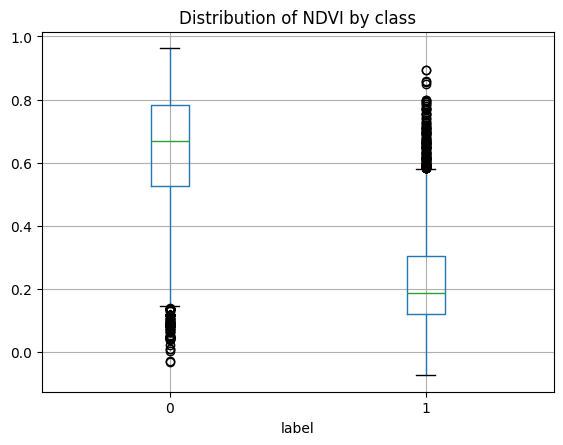

<Figure size 640x480 with 0 Axes>

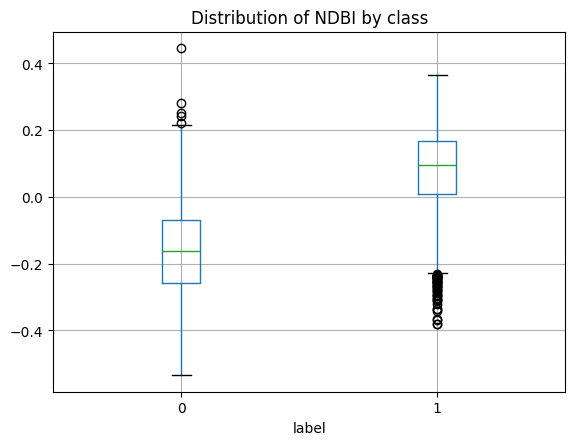

<Figure size 640x480 with 0 Axes>

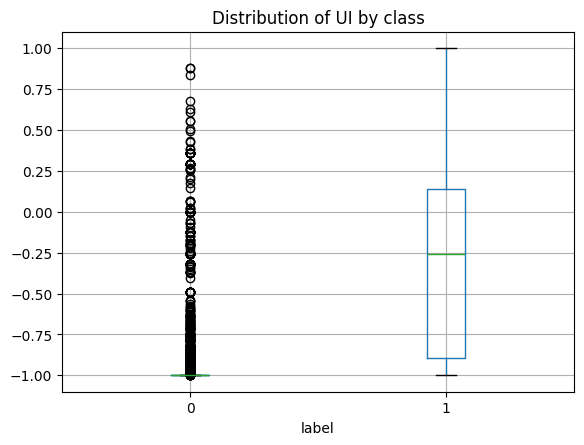

In [25]:
for idx in ['NDVI','NDBI','UI']:
    plt.figure()
    df_clean.boxplot(column=idx, by='label')
    plt.title(f'Distribution of {idx} by class')
    plt.suptitle('')
    plt.show()

### Temporal Train/Validation Split

This code segments your dataset based on acquisition dates, ensuring that the model is trained on earlier scenes and tested on later scenes to prevent temporal leakage.

In [28]:
# 1) Get sorted unique scene dates
unique_dates = sorted(df_clean['raster_date'].unique())

# 2) Define train vs. validation dates
train_dates = unique_dates[:5]   # first 5 scenes
val_dates   = unique_dates[5:]   # last 2 scenes

# 3) Subset your DataFrame
df_train = df_clean[df_clean['raster_date'].isin(train_dates)].copy()
df_val   = df_clean[df_clean['raster_date'].isin(val_dates)].copy()

# 4) Split into features and labels
features = ['NDVI','NDBI','UI']
X_train, y_train = df_train[features], df_train['label']
X_val,   y_val   = df_val[features],   df_val['label']

# 5) Check sizes and class balance
print(f"Train set: {X_train.shape[0]} samples from dates {train_dates}")
print(f"Val   set: {X_val.shape[0]} samples from dates {val_dates}")
print("\nTrain class counts:\n", y_train.value_counts())
print("\nVal class counts:\n",   y_val.value_counts())


Train set: 5400 samples from dates [Timestamp('2018-08-07 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-07-18 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2020-01-09 00:00:00')]
Val   set: 2160 samples from dates [Timestamp('2020-02-18 00:00:00'), Timestamp('2023-08-26 00:00:00')]

Train class counts:
 label
0    2800
1    2600
Name: count, dtype: int64

Val class counts:
 label
0    1120
1    1040
Name: count, dtype: int64


### Model Training and Evaluation

We train a Random Forest classifier on the temporally split training data and evaluate its performance on the held-out validation set.

In [29]:
# Libraries for model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [32]:
# 1) Initialize the Random Forest classifier
#    - 100 trees, no maximum depth (let the trees grow fully)
#    - Use all CPU cores for speed (n_jobs=-1)
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2) Fit the model on the training data
#    X_train: features ['NDVI','NDBI','UI']
#    y_train: labels (0 or 1)
clf.fit(X_train, y_train)
print("Model training complete.")

# 3) Make predictions on the validation set
y_pred = clf.predict(X_val)
print("Predictions on validation set generated.")

# 4. Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.3f}")

# 5. Display confusion matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 6. Show full classification report (precision, recall, f1-score)
report = classification_report(y_val, y_pred)
print("\nClassification Report:")
print(report)

Model training complete.
Predictions on validation set generated.
Validation Accuracy: 0.844

Confusion Matrix:
[[924 196]
 [141 899]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1120
           1       0.82      0.86      0.84      1040

    accuracy                           0.84      2160
   macro avg       0.84      0.84      0.84      2160
weighted avg       0.85      0.84      0.84      2160



### Results Summary

The Random Forest model trained on spectral indices (NDVI, NDBI, and UI) achieved an **overall accuracy** of **84.4%** on the validation set, meaning it correctly classified **84.4%** of the 2,160 unseen samples.

The **confusion matrix** shows:
- **924 of 1,120** vegetation points (class 0) were identified correctly, while **196** were misclassified as urban.
- **899 of 1,040** urban points (class 1) were identified correctly, while **141** were labeled as vegetation.

These counts of correct and incorrect predictions demonstrate a good balance: the model reliably captures both classes without bias.

The **classification report** provides per-class metrics:
- **Precision**: the fraction of positive predictions that are actually correct.
- **Recall**: the fraction of actual positives that the model correctly identifies.
- **F1-score**: the harmonic mean of precision and recall, penalizing both false positives and false negatives.
- **Support**: the number of true instances for each class.

In this case, the F1-scores for both class 0 and class 1 are around **0.84–0.85**, confirming balanced and robust performance in distinguishing vegetation from urban areas on dates the model has never seen.